In [1]:
import pandas as pd
import mlflow

In [2]:
df = pd.read_csv('../Dataset/retail_sales.csv')

In [3]:
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

D:\temp\ipykernel_24132\4183834281.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)


In [4]:
df.set_index('Date', inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52585 entries, 2015-01-01 00:00:00 to 2020-12-31 00:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Sales   52585 non-null  float64
dtypes: float64(1)
memory usage: 821.6 KB


In [6]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2, shuffle=False)


In [7]:
train

,Sales
Date,
2015-01-01 00:00:00,54.048619
2015-01-01 01:00:00,50.161596
2015-01-01 02:00:00,55.954939
2015-01-01 03:00:00,56.553261
2015-01-01 04:00:00,60.487874
...,...
2019-10-19 15:00:00,126.608572
2019-10-19 16:00:00,125.303887
2019-10-19 17:00:00,123.775680


<Axes: title={'center': 'Retail Sales'}, xlabel='Date'>

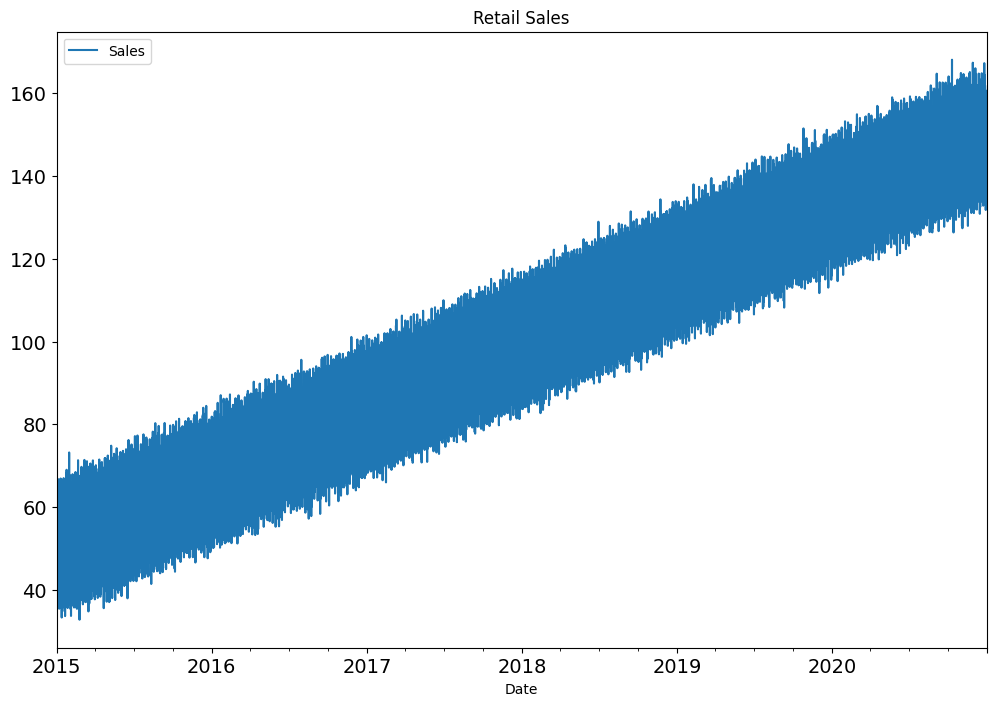

In [8]:
from matplotlib import pyplot as plt

df.plot(title='Retail Sales', figsize=(12, 8), fontsize=14)


In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df['Sales'] = scaler.fit_transform(df[['Sales']])

In [10]:
import numpy as np

def create_sequences(data, index, window_size):
    X, y, timestamps = [], [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
        timestamps.append(index[i + window_size])
    return np.array(X), np.array(y), np.array(timestamps)

window_size=24

train_X, train_y, train_ts = create_sequences(train['Sales'].values, train.index, window_size)
test_X, test_y, test_ts = create_sequences(test['Sales'].values, test.index, window_size)




In [11]:
X_train, X_test = train_X, test_X
y_train, y_test = train_y, test_y
ts_train, ts_test = train_ts, test_ts

In [12]:
import numpy as np

def save_preprocessed_data(filepath, X_train, y_train, ts_train, X_test, y_test, ts_test):
    np.savez(filepath,
             X_train=X_train,
             y_train=y_train,
             ts_train=ts_train,
             X_test=X_test,
             y_test=y_test,
             ts_test=ts_test)


In [13]:
save_preprocessed_data("retail_sales_preprocessed.npz", 
                       X_train, y_train, ts_train, 
                       X_test, y_test, ts_test)


In [14]:
def load_preprocessed_data(filepath):
    data = np.load(filepath, allow_pickle=True)
    return (data['X_train'], data['y_train'], data['ts_train'],
            data['X_test'], data['y_test'], data['ts_test'])


In [15]:
X_train, y_train, ts_train, X_test, y_test, ts_test = load_preprocessed_data("retail_sales_preprocessed.npz")


In [16]:
print("Train lengths")
print(f"train = {len(train)}")
print(f"X_train = {len(X_train)}")

print("Test length")
print(f"test = {len(test)}")
print(f"X_test = {len(X_test)}")

Train lengths
train = 42068
X_train = 42044
Test length
test = 10517
X_test = 10493


# MLFLOW

In [22]:
import mlflow
import mlflow.tensorflow
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
from kerastuner.tuners import RandomSearch

# Enable autologging
mlflow.tensorflow.autolog()

# Define model builder for KerasTuner
def build_model(hp):
    model = Sequential()
    
    # Choose model type
    model_type = hp.Choice('model_type', ['LSTM', 'GRU', 'Dense'])
    units = hp.Int('units', min_value=32, max_value=128, step=16)
    layers = hp.Int('num_layers', 1, 3)
    
    for i in range(layers):
        return_seq = i < layers - 1
        if model_type == 'LSTM':
            model.add(LSTM(units, activation='relu', return_sequences=return_seq,
                           input_shape=(window_size, 1) if i == 0 else None))
        elif model_type == 'GRU':
            model.add(GRU(units, activation='relu', return_sequences=return_seq,
                          input_shape=(window_size, 1) if i == 0 else None))
        else:
            # Dense model flattens and feeds to Dense layers
            if i == 0:
                model.add(tf.keras.layers.Flatten(input_shape=(window_size, 1)))
            model.add(Dense(units, activation='relu'))
    
    model.add(Dense(1))  # Output layer
    model.compile(
        optimizer=keras.optimizers.Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
        loss='mse'
    )
    
    return model

# Setup KerasTuner
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='mlruns_tuning',
    project_name='degradation_prediction'
)

# Search for best hyperparams (inside mlflow run)
with mlflow.start_run(run_name="hyperparam_tuning"):
    tuner.search(X_train, y_train,
                 epochs=10,
                 batch_size=32,
                 validation_data=(X_test, y_test))

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Log the best model explicitly
mlflow.tensorflow.log_model(best_model, "best_model")


Trial 10 Complete [00h 08m 50s]
val_loss: 9.163251876831055

Best val_loss So Far: 6.0481390953063965
Total elapsed time: 00h 24m 48s


g:\Rahul Personal\time-series-mlops\myenv\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
2025/04/21 14:58:43 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/04/21 14:58:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


# Tensorflow

In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(50, activation='relu', input_shape=(window_size, 1)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/10


g:\Rahul's Projects\Timeseries-MLops\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1314/1314 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 126.3450 - val_loss: 7.2118
Epoch 2/10
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 13.6499 - val_loss: 8.9621
Epoch 3/10
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 6.8715 - val_loss: 7.5108
Epoch 4/10
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 6.9017 - val_loss: 9.1244
Epoch 5/10
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 6.8734 - val_loss: 6.4051
Epoch 6/10
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 6.6454 - val_loss: 10.3301
Epoch 7/10
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 6.6626 - val_loss: 6.2570
Epoch 8/10
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 6.5035 - val_loss: 6.7869
Epoch 9/10
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 6.3197 - val_loss: 6.1565
Epoch 10/10
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 6.4831 - val_loss: 6.6347


In [23]:
# Predict
y_pred = model.predict(X_test)

328/328 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


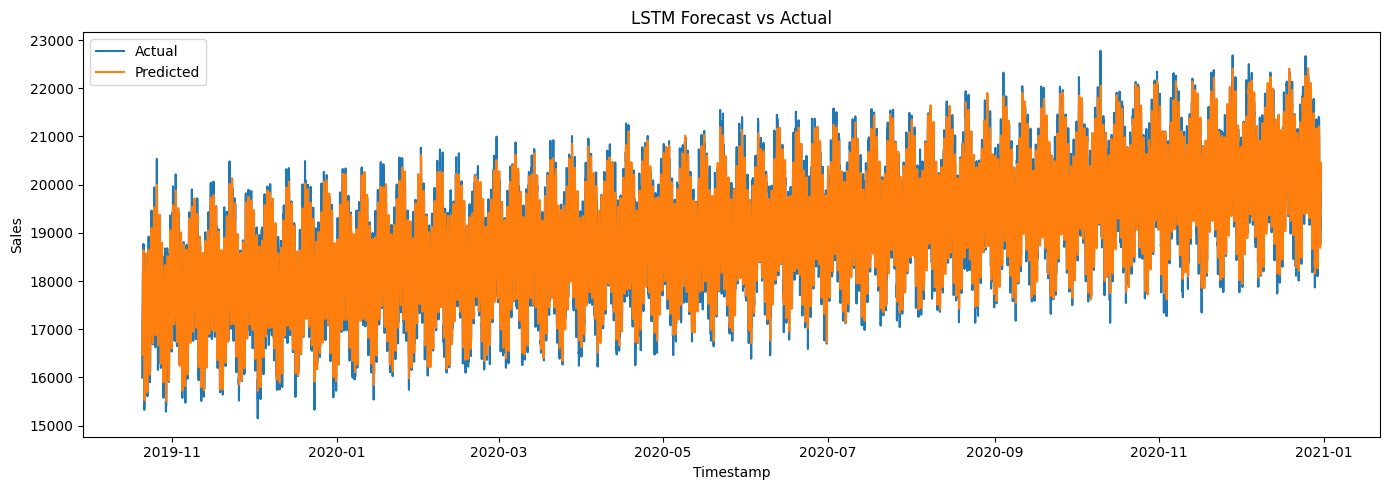

In [24]:
# Inverse scale (optional)
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot with datetime index
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.plot(ts_test, y_test_rescaled, label='Actual')
plt.plot(ts_test, y_pred_rescaled, label='Predicted')
plt.xlabel("Timestamp")
plt.ylabel("Sales")
plt.title("LSTM Forecast vs Actual")
plt.legend()
plt.tight_layout()
plt.show()

In [30]:
output = pd.DataFrame({
    'Actual': y_test_rescaled.flatten(),
    'Predicted': y_pred_rescaled.flatten()
})

In [26]:
output

,Actual,Predicted
0,15995.642263,16477.197266
1,16867.048581,16586.611328
2,17097.349414,16967.203125
3,17367.605468,17341.087891
4,17391.600930,17649.257812
...,...,...
10488,19105.314616,19478.853516
10489,19729.741849,19615.683594
10490,19583.970968,19959.564453
10491,20044.891159,20351.517578


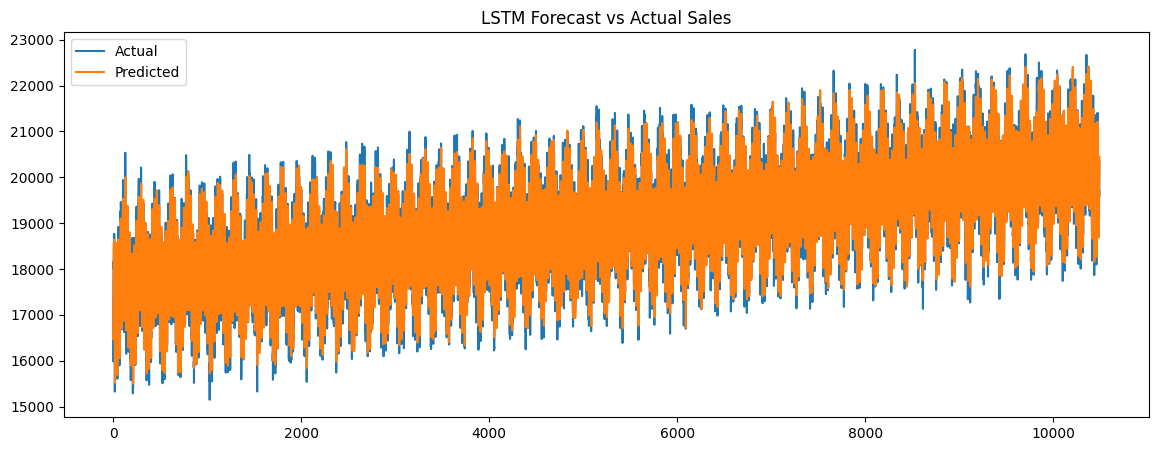

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.plot(y_test_rescaled, label='Actual')
plt.plot(y_pred_rescaled, label='Predicted')
plt.legend()
plt.title("LSTM Forecast vs Actual Sales")
plt.show()
